# Import Modules

In [ ]:
import torch

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100
from torch.cuda import is_available
from torchvision import transforms
from datetime import datetime
%matplotlib inline

In [ ]:
device='cuda' if is_available() else 'cpu'

# Download dataset and calculate means and stds

In [ ]:
all_data=CIFAR100(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to .
Mean: 0.50707513 0.48654887 0.44091785
Std: 0.20079845 0.19834627 0.20219834


# Implement CustomSubset
To use different augmentations to train subset and validation subset.

In [ ]:
class CustomSubset(Dataset):
    def __init__(self,Subset,transform=None):
        super(CustomSubset,self).__init__()
        self.Subset=Subset
        self.indices=Subset.indices
        self.transform=transform

    def __len__(self):
        return len(self.Subset)

    def __getitem__(self,idx):
        img,label=self.Subset[idx]
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [ ]:
transform={
    'train':transforms.Compose([
                                transforms.RandomCrop((32, 32), padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ]),
    'test':transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ])
}

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])

all_data.transform=None
train_data=CustomSubset(train_data,transform['train'])
valid_data=CustomSubset(valid_data,transform['test'])
test_data=CIFAR100(root='.',train=False,transform=transform['test'],download=True)

Files already downloaded and verified


# Define blocks

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)

        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class InceptionA(nn.Module):
    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()

        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5 = nn.Sequential(BasicConv2d(in_channels, 48, kernel_size=1),
                                        BasicConv2d(48, 64, kernel_size=5, padding=2))
        
        self.branch3x3dbl = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1),
                                          BasicConv2d(64, 96, kernel_size=3, padding=1),
                                          BasicConv2d(96, 96, kernel_size=3, padding=1))

        self.branch_pool = nn.Sequential(nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                                         BasicConv2d(in_channels, pool_features, kernel_size=3, padding=1))

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5(x)

        branch3x3dbl = self.branch3x3dbl(x)

        branch_pool = self.branch_pool(x)

        outputs = torch.cat([branch1x1, branch5x5, branch3x3dbl, branch_pool], dim=1)

        return outputs


class InceptionB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionB, self).__init__()

        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1),
                                          BasicConv2d(64, 96, kernel_size=3, padding=1),
                                          BasicConv2d(96, 96, kernel_size=3, stride=2))
        
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl(x)

        branch_pool = self.branch_pool(x)

        outputs = torch.cat([branch3x3, branch3x3dbl, branch_pool], dim=1)

        return outputs


class InceptionC(nn.Module):
    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        self.branch7x7 = nn.Sequential(BasicConv2d(in_channels, channels_7x7, kernel_size=1),
                                       BasicConv2d(channels_7x7, channels_7x7, kernel_size=(1,7), padding=(0,3)),
                                       BasicConv2d(channels_7x7, 192, kernel_size=(7,1), padding=(3,0)))
        
        self.branch7x7dbl = nn.Sequential(BasicConv2d(in_channels, channels_7x7, kernel_size=1),
                                          BasicConv2d(channels_7x7, channels_7x7, kernel_size=(7,1), padding=(3,0)),
                                          BasicConv2d(channels_7x7, channels_7x7, kernel_size=(1,7), padding=(0,3)),
                                          BasicConv2d(channels_7x7, channels_7x7, kernel_size=(7,1), padding=(3,0)),
                                          BasicConv2d(channels_7x7, 192, kernel_size=(1,7), padding=(0,3)))
        
        self.branch_pool = nn.Sequential(nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                                         BasicConv2d(in_channels, 192, kernel_size=1))
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7(x)

        branch7x7dbl = self.branch7x7dbl(x)

        branch_pool = self.branch_pool(x)

        outputs = torch.cat([branch1x1, branch7x7, branch7x7dbl, branch_pool], dim=1)

        return outputs


class InceptionD(nn.Module):
    def __init__(self, in_channels):
        super(InceptionD, self).__init__()

        self.branch3x3 = nn.Sequential(BasicConv2d(in_channels, 192, kernel_size=1),
                                       BasicConv2d(192, 320, kernel_size=3, stride=2))
        
        self.branch7x7x3 = nn.Sequential(BasicConv2d(in_channels, 192, kernel_size=1),
                                         BasicConv2d(192, 192, kernel_size=(1,7), padding=(0,3)),
                                         BasicConv2d(192, 192, kernel_size=(7,1), padding=(3,0)),
                                         BasicConv2d(192, 192, kernel_size=3, stride=2))
        
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch7x7x3 = self.branch7x7x3(x)

        branch_pool = self.branch_pool(x)

        outputs = torch.cat([branch3x3, branch7x7x3, branch_pool], dim=1)

        return outputs


class InceptionE(nn.Module):
    def __init__(self, in_channels):
        super(InceptionE, self).__init__()

        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1,3), padding=(0,1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3,1), padding=(1,0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1,3), padding=(0,1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3,1), padding=(1,0))

        self.branch_pool = nn.Sequential(nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                                         BasicConv2d(in_channels, 192, kernel_size=1))
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3_2a = self.branch3x3_2a(branch3x3)
        branch3x3_2b = self.branch3x3_2b(branch3x3)
        branch3x3 = torch.cat([branch3x3_2a, branch3x3_2b], dim=1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl_3a = self.branch3x3dbl_3a(branch3x3dbl)
        branch3x3dbl_3b = self.branch3x3dbl_3b(branch3x3dbl)
        branch3x3dbl = torch.cat([branch3x3dbl_3a, branch3x3dbl_3b], dim=1)

        branch_pool = self.branch_pool(x)

        outputs = torch.cat([branch1x1, branch3x3, branch3x3dbl, branch_pool], dim=1)
        return outputs


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01

        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001
        
    def forward(self, x):
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        x = self.conv0(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define Inception V3

In [ ]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False, init_weights=None, dropout=0.5):
        super(InceptionV3, self).__init__()

        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.Conv2d_1 = BasicConv2d(3, 32, kernel_size=3, stride=2, padding=1)

        self.Conv2d_2 = nn.Sequential(BasicConv2d(32, 32, kernel_size=3, padding=1),
                                      BasicConv2d(32, 64, kernel_size=3, padding=1))
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.Conv2d_3 = BasicConv2d(64, 80, kernel_size=1)
        
        self.Conv2d_4 = BasicConv2d(80, 192, kernel_size=3)
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.Mixed_5 = nn.Sequential(InceptionA(192, pool_features=32),
                                     InceptionA(256, pool_features=64),
                                     InceptionA(288, pool_features=64))
        
        self.Mixed_6 = nn.Sequential(InceptionB(288),
                                     InceptionC(768, channels_7x7=128),
                                     InceptionC(768, channels_7x7=160),
                                     InceptionC(768, channels_7x7=160),
                                     InceptionC(768, channels_7x7=192))
        
        self.AuxLogits = None
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)

        self.Mixed_7 = nn.Sequential(InceptionD(768),
                                     InceptionE(1280),
                                     InceptionE(2048))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2048, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    stddev = float(m.stddev) if hasattr(m, "stddev") else 0.1  # type: ignore
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=stddev, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat([x_ch0, x_ch1, x_ch2], dim=1)
            
        x = self.Conv2d_1(x)
        x = self.Conv2d_2(x)
        # x = self.maxpool1(x) # no pooling for CIFAR100

        x = self.Conv2d_3(x)
        x = self.Conv2d_4(x)
        # x = self.maxpool2(x) # no pooling for CIFAR100

        x = self.Mixed_5(x)
        x = self.Mixed_6(x)

        aux = None
        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        
        x = self.Mixed_7(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, aux


# Prepare training step

In [ ]:
batch_size=128

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [ ]:
model=InceptionV3(num_classes=100, aux_logits=False)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)

model=model.to(device)
criterion=criterion.to(device)

# Train and validation

In [ ]:
def train(model,criterion,optimizer,train_loader,valid_loader,num_epochs=10,print_every=1,early_stop=None,model_path='vgg.pth'):
    train_logs={'Loss':[],'Accuracy':[]}
    valid_logs={'Loss':[],'Accuracy':[]}
    try:
        patience=0
        best_acc=-np.inf
        start_time = datetime.now()
        for epoch in range(num_epochs):
            train_loss=0
            valid_loss=0
            train_acc=0
            valid_acc=0
            # training step
            model.train()
            for data,target in train_loader:
                optimizer.zero_grad()
                data,target=data.to(device),target.to(device)
                pred, _=model(data)
                loss=criterion(pred,target)
                loss.backward()
                optimizer.step()
                train_loss+=loss.item()*data.size(0)
                train_acc+=torch.sum(pred.argmax(1)==target).item()
            train_loss/=len(train_data)
            train_acc/=len(train_data)
            train_logs['Loss'].append(train_loss)
            train_logs['Accuracy'].append(train_acc)
            if (epoch+1)%print_every==0:
                print('Training   Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch,train_loss,train_acc*100,datetime.now()-start_time))
            # validation step
            with torch.no_grad():
                model.eval()
                for data,target in valid_loader:
                    data,target=data.to(device),target.to(device)
                    pred, _=model(data)
                    loss=criterion(pred,target)
                    valid_loss+=loss.item()*data.size(0)
                    valid_acc+=torch.sum(pred.argmax(1)==target).item()
                valid_loss/=len(valid_data)
                valid_acc/=len(valid_data)
                valid_logs['Loss'].append(valid_loss)
                valid_logs['Accuracy'].append(valid_acc)
                if (epoch+1)%print_every==0:
                    print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch,valid_loss,valid_acc*100,datetime.now()-start_time))
                if valid_acc>best_acc:
                    best_acc=valid_acc
                    torch.save(model.state_dict(),model_path)
                    if early_stop is not None:
                        patience=0
                elif early_stop is not None:
                    patience+=1
                    if patience>=early_stop:
                        print('Training finished by early stopping')
                        return train_logs,valid_logs
        return train_logs,valid_logs
    except KeyboardInterrupt:
        return train_logs, valid_logs

In [ ]:
train_logs,valid_logs = train(model=model,
                              criterion=criterion,
                              optimizer=optimizer,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              num_epochs=50,
                              print_every=1,
                              early_stop=None,
                              model_path='inception_v3.pth')

Training   Epoch 0 - Loss : 4.39490073 Accuracy : 3.9500% Time elapsed: 0:00:58.760244
Validation Epoch 0 - Loss : 4.15704762 Accuracy : 5.9600%
Training   Epoch 1 - Loss : 4.04000319 Accuracy : 7.5075% Time elapsed: 0:02:01.317744
Validation Epoch 1 - Loss : 3.90213085 Accuracy : 10.1900%
Training   Epoch 2 - Loss : 3.81794973 Accuracy : 10.7875% Time elapsed: 0:03:03.855038
Validation Epoch 2 - Loss : 3.71725070 Accuracy : 12.2300%
Training   Epoch 3 - Loss : 3.65708578 Accuracy : 13.5550% Time elapsed: 0:04:06.339745
Validation Epoch 3 - Loss : 3.52179576 Accuracy : 15.7100%
Training   Epoch 4 - Loss : 3.49110581 Accuracy : 16.3650% Time elapsed: 0:05:08.923309
Validation Epoch 4 - Loss : 3.43002825 Accuracy : 18.1200%
Training   Epoch 5 - Loss : 3.34493741 Accuracy : 19.1725% Time elapsed: 0:06:11.441668
Validation Epoch 5 - Loss : 3.31530778 Accuracy : 19.7700%
Training   Epoch 6 - Loss : 3.20073863 Accuracy : 21.5750% Time elapsed: 0:07:13.920649
Validation Epoch 6 - Loss : 3.156

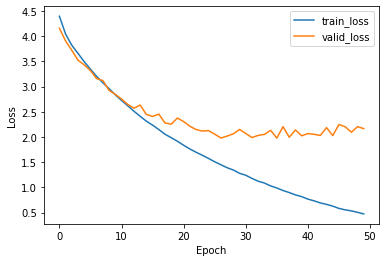

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))],train_logs['Loss'],label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))],valid_logs['Loss'],label='valid_loss')
plt.legend()
plt.show()

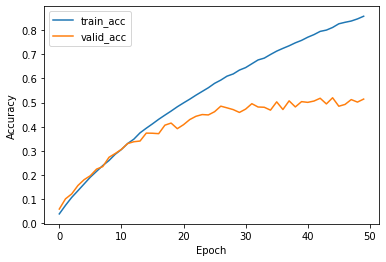

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))],train_logs['Accuracy'],label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))],valid_logs['Accuracy'],label='valid_acc')
plt.legend()
plt.show()

# Test

In [ ]:
model.load_state_dict(torch.load('inception_v3.pth'))
model=model.to(device)

In [ ]:
def test(model,criterion,test_loader):
    test_loss=0
    test_acc=0
    result_table=pd.DataFrame(columns=['Prediction','Target'])
    with torch.no_grad():
        model.eval()
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            pred,_=model(data)
            loss=criterion(pred,target)
            test_loss+=loss.item()*data.size(0)
            test_acc+=torch.sum(pred.argmax(1)==target).item()
            for p,t in zip(pred.argmax(1),target):
                result_table=result_table.append({'Prediction':p.item(),'Target':t.item()},ignore_index=True)
        test_loss/=len(test_data)
        test_acc/=len(test_data)
    return test_loss,test_acc,result_table

In [ ]:
test_loss,test_acc,result_table=test(model=model,
                                     criterion=criterion,
                                     test_loader=test_loader)

In [ ]:
print('Test Loss : {:.8f} Test Accuracy : {:.4f}%'.format(test_loss,test_acc*100))

Test Loss : 2.02562830 Test Accuracy : 52.8000%


In [ ]:
result_table

,Prediction,Target
0,72,49
1,56,33
2,55,72
3,89,51
4,71,71
...,...,...
9995,83,83
9996,65,14
9997,51,51
9998,42,42
